# **Brain Tumor Segmentation Using MONAI and Multi-Model Comparison on BraTS-GLI 2025**

# Dataset Access and Preparation — BraTS 2025 (BraTS-GLI Pre-treatment)

To use the BraTS 2025 (BraTS-GLI Pre-treatment) dataset, follow these steps:
  * Create an Account on Synapse
  Go to https://www.synapse.org/ and sign up for a free account.
  * Register for the BraTS 2025 Challenge
  Visit the official challenge page, register for the competition, and accept the terms.
  * Request Dataset Access
  Fill and submit the data access request form to gain permission to download the dataset.
  * Download and Upload to Google Drive
  Once approved, download the dataset and upload it to a specific folder in your Google Drive.
  * Link to Google Drive [My Goolge Drive Link](https://drive.google.com/drive/folders/1H3xPtRZmys5JTb1AVi9pVHieMEjKfGpL?usp=drive_link) & [Another](https://drive.google.com/drive/folders/178caOjtx9-4xSZgfbGO9XY8fIulnrzGj?usp=drive_link)

data_dir = "/content/drive/MyDrive/BraTS2025-sample"

✅ This setup ensures reproducible access and smooth integration of BraTS 2025 data into your Colab workflow.

# 0. Connect to Google Drive

📝 Description: Mounts the user’s Google Drive within the Colab environment using drive.mount():

* Enables access to external datasets or files stored in Google Drive.
* Required for reading and writing data such as BraTS MRI files, models, and results.
* The mounted path becomes accessible under /content/drive.

Essential for file I/O in Colab when working with large datasets or saving results persistently.

In [ ]:
# prompt: connect with drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Install MONAI with All Optional Dependencies

📝 Description: Installs the MONAI framework along with all its extended dependencies using:

* Ensures support for advanced transforms, metrics, and model components required for medical imaging workflows.
* Includes compatibility with PyTorch, ITK, DICOM, visualization tools, and more.
* Essential for running MONAI-based training, preprocessing, and evaluation pipelines.

⚠️ Note: After installation, you must restart the runtime to ensure all packages are correctly loaded by Colab.

In [ ]:
pip install "monai[all]"

# 2. Imports for MONAI-based 3D Medical Image Segmentation Pipeline

📝 Description: This section sets up all necessary libraries for building a brain tumor segmentation workflow using the MONAI framework. It includes tools for:



*   Data loading and preprocessing (os, nibabel, numpy, matplotlib)
*   PyTorch-based deep learning operations (torch)
*   MONAI transforms for 3D medical imaging
*   Built-in segmentation models (UNet, SwinUNETR, DynUNet)
*   Evaluation metrics and loss functions
*   Efficient inference and data pipelines

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, NormalizeIntensityd,
    ResizeWithPadOrCropd, RandFlipd, RandRotate90d, ToTensord,
    Spacingd, Orientationd, ScaleIntensityd, ConcatItemsd, RandCropByPosNegLabeld
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.networks.nets import UNet, SwinUNETR, DynUNet
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric, HausdorffDistanceMetric, ConfusionMatrixMetric, SurfaceDistanceMetric
from monai.inferers import sliding_window_inference
from monai.utils import first, set_determinism
from glob import glob

# 3. Data Directory Scanning and Modality Mapping for BraTS Dataset

📝 Description: This block performs critical setup for training:

* Sets a random seed to ensure reproducible results.
* Detects and prints whether a GPU is available for training.
* Scans the dataset directory for individual subject folders.
* Within each subject folder, it maps MRI modality files (T1ce, T1, T2, FLAIR and segmentation masks) based on filename patterns.
* Constructs a data_dicts list containing file paths grouped by modality.
* Filters out incomplete subjects, ensuring only samples with all required modalities are included.

In [ ]:
# Set seed for reproducibility
set_determinism(seed=42)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data directory
data_dir = "/content/drive/MyDrive/BraTS2025-sample"

# Build data dictionaries from folder contents
subjects = [os.path.join(data_dir, folder) for folder in os.listdir(data_dir)]
data_dicts = []

for subject in subjects:
    files = [f for f in os.listdir(subject) if f.endswith(".nii") or f.endswith(".nii.gz")]
    file_map = {}

    # Map file types based on their names
    for f in files:
        if "t1c" in f or "t1ce" in f:
            key = "t1c"
        elif "t1n" in f or "-t1" in f:
            key = "t1n"
        elif "t2f" in f or "flair" in f:
            key = "t2f"
        elif "t2w" in f or "-t2" in f:
            key = "t2w"
        elif "seg" in f:
            key = "seg"
        else:
            continue

        file_map[key] = os.path.join(subject, f)

    # Check if all required files exist
    if all(k in file_map for k in ["t1c", "t1n", "t2f", "t2w", "seg"]):
        data_dict = {
            "t1c": file_map["t1c"],
            "t1n": file_map["t1n"],
            "t2f": file_map["t2f"],
            "t2w": file_map["t2w"],
            "seg": file_map["seg"]
        }
        data_dicts.append(data_dict)

print(f"✅ Number of complete samples found: {len(data_dicts)}")
if len(data_dicts) == 0:
    raise ValueError("No valid samples found. Check file names or directory structure.")

Using device: cuda
✅ Number of complete samples found: 100


# 4. Data Augmentation and Preprocessing Transforms for Multi-Modal MRI Input

📝 Description: Defines preprocessing pipelines for training and validation using MONAI transforms:

* Standardizes spatial orientation and size of input volumes.
* Normalizes intensities of the 4 input MRI modalities (t1c, t1n, t2f, t2w).
* Concatenates modalities into a single 4-channel image tensor.
* Applies data augmentations (random flipping, rotations, and class-balanced cropping) during training to improve generalization.
* Uses deterministic preprocessing only during validation to maintain consistency.
* Ensures output is in PyTorch tensor format for model input.

In [ ]:
# 2. Updated Transforms for Multi-Modal Input
# Define target spatial size based on your specified dimensions
target_size = (192, 224, 192)

# Training transforms
train_transforms = Compose([
    LoadImaged(keys=["t1c", "t1n", "t2f", "t2w", "seg"]),
    EnsureChannelFirstd(keys=["t1c", "t1n", "t2f", "t2w", "seg"]),
    Orientationd(keys=["t1c", "t1n", "t2f", "t2w", "seg"], axcodes="RAS"),
    ResizeWithPadOrCropd(keys=["t1c", "t1n", "t2f", "t2w", "seg"], spatial_size=target_size),
    ScaleIntensityd(keys=["t1c", "t1n", "t2f", "t2w"]),  # Normalize each modality
    ConcatItemsd(keys=["t1c", "t1n", "t2f", "t2w"], name="image", dim=0),  # Concatenate to 4-channel input
    RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=0),
    RandRotate90d(keys=["image", "seg"], prob=0.5, max_k=3),
    RandCropByPosNegLabeld(
        keys=["image", "seg"],
        label_key="seg",
        spatial_size=(96, 96, 96),  # Smaller crop for training efficiency
        pos=1,
        neg=1,
        num_samples=4,
    ),
    ToTensord(keys=["image", "seg"])
])

# Validation transforms (no random operations)
val_transforms = Compose([
    LoadImaged(keys=["t1c", "t1n", "t2f", "t2w", "seg"]),
    EnsureChannelFirstd(keys=["t1c", "t1n", "t2f", "t2w", "seg"]),
    Orientationd(keys=["t1c", "t1n", "t2f", "t2w", "seg"], axcodes="RAS"),
    ResizeWithPadOrCropd(keys=["t1c", "t1n", "t2f", "t2w", "seg"], spatial_size=target_size),
    ScaleIntensityd(keys=["t1c", "t1n", "t2f", "t2w"]),
    ConcatItemsd(keys=["t1c", "t1n", "t2f", "t2w"], name="image", dim=0),
    ToTensord(keys=["image", "seg"])
])

# 5. Train/Validation Split and DataLoader Creation

📝 Description: Splits the prepared dataset into training and validation subsets:

* Uses train_test_split to allocate 80% of samples for training and 20% for validation.
* Wraps data into CacheDataset to speed up training by caching transformed data.
* Initializes DataLoaders for efficient batch loading during training and validation.
* Prints shapes of the first image and segmentation tensor to verify correctness of preprocessing and batching.

In [ ]:
# 3. Create Train/Validation Split
# Split data into training and validation
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(data_dicts, test_size=0.2, random_state=42)
print(f"Training samples: {len(train_files)}, Validation samples: {len(val_files)}")

# Create datasets
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)

# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

# Check the first batch to confirm data shape
check_data = first(train_loader)
print(f"Image shape: {check_data['image'].shape}")  # Should be [B, C, H, W, D]
print(f"Segmentation shape: {check_data['seg'].shape}")

Training samples: 80, Validation samples: 20


Loading dataset: 100%|██████████| 20/20 [03:07<00:00,  9.39s/it]


Image shape: torch.Size([4, 4, 96, 96, 96])
Segmentation shape: torch.Size([4, 1, 96, 96, 96])


# 6. Model Definitions for Multi-Modal Brain Tumor Segmentation

📝 Description: Defines three 3D segmentation model architectures compatible with 4-channel MRI input:

 * UNet: A standard convolutional model using a deep encoder-decoder architecture with skip connections.
 * Swin UNETR: A transformer-based architecture (SwinUNETR) that incorporates self-attention for improved global context understanding.
 * DynUNet (nnUNet): A flexible and scalable U-Net variant (DynUNet) with configurable kernel sizes, strides, and optional deep supervision.

*  Each model:

 * Accepts 4 input channels representing different MRI modalities.
 * Outputs a single binary segmentation channel (set out_channels > 1 for multi-class).
 * Uses the same spatial dimensions and is configured to match preprocessing pipelines.
 * DynUNet has deep supervision disabled to prevent shape mismatch errors during training.

In [ ]:
# 4. Updated Model Definitions for 4-channel Input
# Standard UNet
unet = UNet(
    spatial_dims=3,
    in_channels=4,  # 4 input channels for t1c, t1n, t2f, t2w
    out_channels=1,  # Binary segmentation (can change to 3 or 4 for multi-class)
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2
)

# Swin UNETR
swin_unetr = SwinUNETR(
    img_size=target_size,  # Use the target size we specified
    in_channels=4,
    out_channels=1,
    feature_size=48,
    use_checkpoint=True
)

# DynUNet (nnUNet)
# Adapt to match your target dimensions
# First, let's fix the model definition for nnUNet (DynUNet)
# The issue is with deep supervision causing dimension mismatch
# First, let's fix the model definition for nnUNet (DynUNet)
# The issue is with deep supervision causing dimension mismatch
nnunet = DynUNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=1,
    kernel_size=[[3, 3, 3]] * 5,
    strides=[[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]],
    upsample_kernel_size=[[2, 2, 2]] * 4,
    norm_name="instance",
    deep_supervision=False,  # Disable deep supervision to fix the dimension issue
    deep_supr_num=0
)

monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().


# 7. Utility Imports for Training, Evaluation, and Visualization

📝 Description: Imports supporting tools required for enhanced training and evaluation:

* time, csv: Used for logging performance metrics and timing.
* torch.nn.functional as F: Access to functions like loss operations or activation functions.
* matplotlib.pyplot: Visualization of images and learning curves.
* monai.visualize.plot_2d_or_3d_image: For visualizing 2D/3D medical images during training or inference.
* torch.cuda.amp: Enables mixed-precision training via autocast and GradScaler, improving speed and memory usage on GPUs.

In [ ]:
# 5. Enhanced Training and Evaluation Functions
import time
import csv
import torch.nn.functional as F
import matplotlib.pyplot as plt
from monai.visualize import plot_2d_or_3d_image
from torch.cuda.amp import GradScaler, autocast

# 8. Robust Training and Evaluation Loop for Medical Image Segmentation

📝 Description: Defines a full training pipeline for 3D segmentation models with support for:

  * Mixed-precision training using autocast and GradScaler for efficient GPU memory usage.
  * Flexible loss handling, including support for deep supervision (like in DynUNet).
  * Metrics tracking using MONAI's Dice, Hausdorff, and SurfaceDistance metrics.
  * Sliding window inference during validation for accurate large-volume segmentation.
  * Early stopping with model checkpointing based on best Dice score.
  * Automatic learning rate scheduling using ReduceLROnPlateau.
  * Final evaluation with detailed metrics and result logging to CSV.
  * Visualization of training curves for loss and metric progression.

In [ ]:
# Updated train_and_evaluate function to correctly handle deep supervision outputs
def train_and_evaluate(model, model_name, train_loader, val_loader, device, epochs=50, patience=10):
    """
    Train and evaluate the model with comprehensive metrics.

    Args:
        model: The neural network model
        model_name: Name of the model for logging
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        device: Device to use (cuda/cpu)
        epochs: Number of training epochs
        patience: Patience for early stopping
    """
    model.to(device)

    # Loss function and optimizer
    loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, lambda_ce=0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.2, patience=patience//2
    )

    # Metrics
    dice_metric = DiceMetric(include_background=False, reduction="mean")
    hausdorff_metric = HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95)
    surface_distance_metric = SurfaceDistanceMetric(include_background=False, reduction="mean")

    # For mixed precision training
    scaler = GradScaler()

    # For early stopping
    best_dice = -1
    no_improvement = 0
    best_epoch = 0

    # Results tracking
    results = {
        "train_loss": [],
        "val_loss": [],
        "val_dice": [],
        "val_hausdorff": [],
        "val_surface_dist": [],
        "lr": []
    }

    # Check if model has deep supervision (for nnUNet)
    is_dynunet = isinstance(model, DynUNet) and hasattr(model, 'deep_supervision') and model.deep_supervision

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        step = 0

        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data["image"].to(device), batch_data["seg"].to(device)

            optimizer.zero_grad()

            # Use mixed precision for better GPU utilization
            with autocast():
                outputs = model(inputs)

                # Handle deep supervision outputs
                if is_dynunet:
                    # For DynUNet with deep supervision
                    loss = 0
                    for i, output in enumerate(outputs):
                        loss += loss_function(output, labels) / len(outputs)
                else:
                    # For standard output
                    loss = loss_function(outputs, labels)

            # Backpropagation with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

            # Print progress every 10 steps
            if step % 10 == 0:
                print(f"[{model_name}] Epoch {epoch+1}/{epochs}, Step {step}/{len(train_loader)}, Loss: {loss.item():.4f}")

        # Calculate average training loss
        epoch_loss /= step
        results["train_loss"].append(epoch_loss)
        results["lr"].append(optimizer.param_groups[0]["lr"])

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            # Reset metrics
            dice_metric.reset()
            hausdorff_metric.reset()
            surface_distance_metric.reset()

            for val_data in val_loader:
                val_inputs, val_labels = val_data["image"].to(device), val_data["seg"].to(device)

                # Use sliding window inference for better results
                roi_size = (96, 96, 96)
                val_outputs = sliding_window_inference(val_inputs, roi_size, 4, model, overlap=0.5)

                # Handle deep supervision outputs in inference (will get only the final output)
                if is_dynunet:
                    # For validation we only use the final output
                    val_outputs = val_outputs[0]

                # Calculate validation loss
                loss = loss_function(val_outputs, val_labels)
                val_loss += loss.item()

                # Calculate metrics
                # Convert to binary mask for metric calculation
                val_outputs_binary = (val_outputs > 0.5).float()
                dice_metric(y_pred=val_outputs_binary, y=val_labels)
                hausdorff_metric(y_pred=val_outputs_binary, y=val_labels)
                surface_distance_metric(y_pred=val_outputs_binary, y=val_labels)

            # Calculate average validation metrics
            val_loss /= len(val_loader)
            results["val_loss"].append(val_loss)

            val_dice = dice_metric.aggregate().item()
            val_hausdorff = hausdorff_metric.aggregate().item()
            val_surface_dist = surface_distance_metric.aggregate().item()

            results["val_dice"].append(val_dice)
            results["val_hausdorff"].append(val_hausdorff)
            results["val_surface_dist"].append(val_surface_dist)

            # Update learning rate based on validation loss
            scheduler.step(val_loss)

            # Print validation results
            print(f"[{model_name}] Epoch {epoch+1}/{epochs}, Val Loss: {val_loss:.4f}, "
                  f"Dice: {val_dice:.4f}, HD95: {val_hausdorff:.4f}, "
                  f"Surface Distance: {val_surface_dist:.4f}, "
                  f"LR: {optimizer.param_groups[0]['lr']:.6f}")

            # Check for improvement for early stopping
            if val_dice > best_dice:
                best_dice = val_dice
                best_epoch = epoch
                no_improvement = 0
                # Save the best model
                torch.save(model.state_dict(), f"{model_name}_best_model.pth")
                print(f"★ New best model saved with Dice score: {best_dice:.4f}")
            else:
                no_improvement += 1
                print(f"No improvement for {no_improvement} epochs. Best Dice: {best_dice:.4f} at epoch {best_epoch+1}")

            # Early stopping
            if no_improvement >= patience:
                print(f"Early stopping after {epoch+1} epochs")
                break

    # Load the best model for final evaluation
    model.load_state_dict(torch.load(f"{model_name}_best_model.pth"))
    model.eval()

    # Final comprehensive evaluation
    final_metrics = perform_final_evaluation(model, model_name, val_loader, device, is_dynunet)

    # Save results to CSV
    log_path = f"{model_name}_results.csv"
    with open(log_path, mode="w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Metric", "Value"])
        for metric, value in final_metrics.items():
            writer.writerow([metric, value])

    # Plot training curves
    plot_training_curves(model_name, results)

    return final_metrics

# 9. Final Model Evaluation with Metric Aggregation and Visualization

📝 Description: Performs a detailed post-training evaluation of the trained model on the validation set:

* Computes segmentation metrics: Dice Score, Hausdorff Distance (95th percentile), and Average Surface Distance.
* Measures inference time and GPU memory usage per sample.
* Supports both standard models and deep-supervised architectures (e.g., DynUNet).
* Automatically saves visual comparisons (input image, ground truth, prediction) for the first 5 samples to visualizations/.
* Aggregates and returns all evaluation metrics in a dictionary.
* Prints a clean summary of the final performance results.

In [ ]:
def perform_final_evaluation(model, model_name, val_loader, device, is_dynunet=False):
    """
    Comprehensive final evaluation of the model.

    Args:
        model: The trained model
        model_name: Name of the model
        val_loader: Validation data loader
        device: Device to use (cuda/cpu)
        is_dynunet: Whether the model is a DynUNet with deep supervision

    Returns:
        Dictionary of evaluation metrics
    """
    metrics = {}

    # Set up metrics
    dice_metric = DiceMetric(include_background=False, reduction="mean")
    hausdorff_metric = HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95)
    surface_distance_metric = SurfaceDistanceMetric(include_background=False, reduction="mean")

    # Reset metrics
    dice_metric.reset()
    hausdorff_metric.reset()
    surface_distance_metric.reset()

    # Time measurement
    inference_times = []
    memory_usage = []

    # Visualization directory
    os.makedirs("visualizations", exist_ok=True)

    with torch.no_grad():
        for i, val_data in enumerate(val_loader):
            val_inputs, val_labels = val_data["image"].to(device), val_data["seg"].to(device)

            # Measure starting memory
            start_mem = torch.cuda.memory_allocated() if torch.cuda.is_available() else 0

            # Measure inference time
            start_time = time.time()

            # Use sliding window inference
            roi_size = (96, 96, 96)
            val_outputs = sliding_window_inference(val_inputs, roi_size, 4, model, overlap=0.5)

            # Handle deep supervision outputs
            if is_dynunet:
                val_outputs = val_outputs[0]  # Get only final output

            # Record timing and memory
            inference_time = time.time() - start_time
            inference_times.append(inference_time)

            end_mem = torch.cuda.memory_allocated() if torch.cuda.is_available() else 0
            memory_usage.append((end_mem - start_mem) / (1024 * 1024))  # MB

            # Convert to binary for metrics
            val_outputs_binary = (val_outputs > 0.5).float()

            # Calculate metrics
            dice_metric(y_pred=val_outputs_binary, y=val_labels)
            hausdorff_metric(y_pred=val_outputs_binary, y=val_labels)
            surface_distance_metric(y_pred=val_outputs_binary, y=val_labels)

            # Visualize some examples (first 5)
            if i < 5:
                # Get middle slices for visualization
                slice_idx = val_inputs.shape[2] // 2
                plt.figure(figsize=(15, 5))

                # Original image (show first modality)
                plt.subplot(1, 3, 1)
                plt.title("T1 Post-Contrast")
                plt.imshow(val_inputs[0, 0, slice_idx].cpu(), cmap="gray")
                plt.axis("off")

                # Ground truth
                plt.subplot(1, 3, 2)
                plt.title("Ground Truth")
                plt.imshow(val_labels[0, 0, slice_idx].cpu(), cmap="viridis")
                plt.axis("off")

                # Prediction
                plt.subplot(1, 3, 3)
                plt.title("Prediction")
                plt.imshow(val_outputs_binary[0, 0, slice_idx].cpu(), cmap="viridis")
                plt.axis("off")

                plt.savefig(f"visualizations/{model_name}_sample_{i}.png")
                plt.close()

    # Aggregate metrics
    dice_score = dice_metric.aggregate().item()
    hausdorff_dist = hausdorff_metric.aggregate().item()
    surface_dist = surface_distance_metric.aggregate().item()

    # Average time and memory
    avg_inference_time = sum(inference_times) / len(inference_times)
    avg_memory_usage = sum(memory_usage) / len(memory_usage)

    # Store all metrics
    metrics["Dice Score"] = round(dice_score, 4)
    metrics["Hausdorff Distance 95%"] = round(hausdorff_dist, 4)
    metrics["Average Surface Distance"] = round(surface_dist, 4)
    metrics["Average Inference Time (s)"] = round(avg_inference_time, 4)
    metrics["Average Memory Usage (MB)"] = round(avg_memory_usage, 2)

    # Print results
    print(f"\n===== Final Evaluation for {model_name} =====")
    for key, value in metrics.items():
        print(f"{key}: {value}")
    print("=========================================")

    return metrics

# 10. Training Curve Visualization for Model Diagnostics

📝 Description: Generates a 2×2 subplot of key training diagnostics over epochs:

  * Top Left: Plots training and validation loss to monitor convergence and overfitting.
  * Top Right: Plots validation Dice score to track segmentation quality.
  * Bottom Left: Tracks Hausdorff Distance (95%) for spatial accuracy of boundaries.
  * Bottom Right: Shows learning rate progression, useful with learning rate schedulers.

In [ ]:
def plot_training_curves(model_name, results):
    """Plot training and validation curves for the model"""
    # Create figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(20, 15))

    # Loss curves
    axs[0, 0].plot(results["train_loss"], label="Training Loss")
    axs[0, 0].plot(results["val_loss"], label="Validation Loss")
    axs[0, 0].set_title("Loss Curves")
    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Dice score
    axs[0, 1].plot(results["val_dice"], label="Validation Dice", color="green")
    axs[0, 1].set_title("Dice Score")
    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Dice")
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Hausdorff distance
    axs[1, 0].plot(results["val_hausdorff"], label="Hausdorff Distance", color="red")
    axs[1, 0].set_title("Hausdorff Distance (95%)")
    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("HD95")
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Learning rate
    axs[1, 1].plot(results["lr"], label="Learning Rate", color="purple")
    axs[1, 1].set_title("Learning Rate")
    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("LR")
    axs[1, 1].legend()
    axs[1, 1].grid(True)
    axs[1, 1].set_yscale("log")

    plt.tight_layout()
    plt.savefig(f"{model_name}_training_curves.png")
    plt.close()

# 11. Model Performance Comparison and Visualization

📝 Description: Compares evaluation metrics across multiple trained models:

* Accepts a dictionary of model names with their corresponding evaluation metric results.
* Writes a comparison CSV (model_comparison.csv) for tabular analysis of metrics like Dice, Hausdorff Distance, etc.
* Generates bar plots for each metric to visualize and compare model performance.
* Automatically labels each bar with its value and saves plots as images (comparison_<metric>.png).

In [ ]:
# 6. Model Comparison Function
def compare_models(models_metrics):
    """
    Compare the performance of different models

    Args:
        models_metrics: Dictionary with model names as keys and metric dictionaries as values
    """
    # Create comparison table
    metrics = list(next(iter(models_metrics.values())).keys())
    model_names = list(models_metrics.keys())

    # Save comparison CSV
    with open("model_comparison.csv", mode="w", newline='') as f:
        writer = csv.writer(f)
        # Header
        writer.writerow(["Metric"] + model_names)

        # Data rows
        for metric in metrics:
            row = [metric]
            for model in model_names:
                row.append(models_metrics[model][metric])
            writer.writerow(row)

    # Create bar charts for comparison
    for metric in metrics:
        values = [models_metrics[model][metric] for model in model_names]

        plt.figure(figsize=(10, 6))
        bars = plt.bar(model_names, values)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom')

        plt.title(f'Comparison of {metric} across models')
        plt.ylabel(metric)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.savefig(f"comparison_{metric.replace(' ', '_').lower()}.png")
        plt.close()

# 12. Main Pipeline Execution: Training, Evaluation, and Model Comparison

📝 Description: This block serves as the entry point for executing the full segmentation workflow:

* Trains and evaluates three models: UNet, Swin-UNETR, and DynUNet (nnUNet).
* Wraps each model's training in a try-except block to ensure robust execution and isolate failures.
* Tracks each model’s evaluation metrics in a dictionary for later comparison.
* Runs the compare_models() function to generate a CSV summary and visualization plots.
* Allows easy switching between testing mode (fewer epochs) and full training.

In [ ]:
# 7. Main Execution
if __name__ == "__main__":
    print("Starting model training and evaluation...")

    # Set epochs for quick testing
    testing_epochs = 100  # Use fewer epochs for testing
    full_epochs = 100    # Use more epochs for full training

    # Use a small number of epochs first to check if everything works
    current_epochs = testing_epochs

    # Dictionary to store results for comparison
    all_models_metrics = {}

    try:
        # 1. Train and evaluate UNet
        print("\n===== Training UNet =====")
        metrics_unet = train_and_evaluate(unet, "UNet", train_loader, val_loader, device, epochs=current_epochs)
        all_models_metrics["UNet"] = metrics_unet
    except Exception as e:
        print(f"Error training UNet: {e}")

    try:
        # 2. Train and evaluate Swin-UNETR
        print("\n===== Training Swin-UNETR =====")
        metrics_swin = train_and_evaluate(swin_unetr, "Swin-UNETR", train_loader, val_loader, device, epochs=current_epochs)
        all_models_metrics["Swin-UNETR"] = metrics_swin
    except Exception as e:
        print(f"Error training Swin-UNETR: {e}")

    try:
        # 3. Train and evaluate nnUNet
        print("\n===== Training nnUNet =====")
        # Explicitly disable deep supervision for nnUNet
        nnunet.deep_supervision = False
        metrics_nnunet = train_and_evaluate(nnunet, "nnUNet", train_loader, val_loader, device, epochs=current_epochs)
        all_models_metrics["nnUNet"] = metrics_nnunet
    except Exception as e:
        print(f"Error training nnUNet: {e}")

    # 4. Compare all models if we have results
    if all_models_metrics:
        compare_models(all_models_metrics)

    print("\n===== Completed =====")
    print("Results have been saved to CSV files and visualization images.")
    print("Check the generated outputs for detailed performance metrics and comparisons.")

Starting model training and evaluation...

===== Training UNet =====


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
single channel prediction, `to_onehot_y=True` ignored.


[UNet] Epoch 1/100, Step 10/80, Loss: 0.9794
[UNet] Epoch 1/100, Step 20/80, Loss: 1.3890
[UNet] Epoch 1/100, Step 30/80, Loss: 1.0784
[UNet] Epoch 1/100, Step 40/80, Loss: 1.0876
[UNet] Epoch 1/100, Step 50/80, Loss: 0.8806
[UNet] Epoch 1/100, Step 60/80, Loss: 1.1324
[UNet] Epoch 1/100, Step 70/80, Loss: 0.5768
[UNet] Epoch 1/100, Step 80/80, Loss: 0.9206
[UNet] Epoch 1/100, Val Loss: 1.2592, Dice: 0.0213, HD95: 94.5892, Surface Distance: 58.5134, LR: 0.000100
★ New best model saved with Dice score: 0.0213
[UNet] Epoch 2/100, Step 10/80, Loss: 0.5700
[UNet] Epoch 2/100, Step 20/80, Loss: 0.6833
[UNet] Epoch 2/100, Step 30/80, Loss: 1.1111
[UNet] Epoch 2/100, Step 40/80, Loss: 1.0503
[UNet] Epoch 2/100, Step 50/80, Loss: 0.9501
[UNet] Epoch 2/100, Step 60/80, Loss: 1.3598
[UNet] Epoch 2/100, Step 70/80, Loss: 1.0141
[UNet] Epoch 2/100, Step 80/80, Loss: 0.5766
[UNet] Epoch 2/100, Val Loss: 1.2504, Dice: 0.0231, HD95: 94.2745, Surface Distance: 58.9557, LR: 0.000100
★ New best model sa

# 13. Imports for Visualization and Metric Analysis

📝 Description: Loads supporting libraries for visualizing outputs and analyzing logged metrics:

  * matplotlib.pyplot: For plotting images, metrics, and training curves.
  * os, glob: For accessing saved images and results from the filesystem.
  * pandas: For reading and analyzing CSV logs (e.g., training results, comparisons).
  * numpy: For numerical operations on logged metrics and image arrays.

In [ ]:
# Visualization Code Block
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import numpy as np

# 14. Comprehensive Visualization of Model Performance and Predictions

📝 Description: This function consolidates and displays all visual outputs and evaluation results post-training:

* Loads and compares evaluation metrics across models, plotting bar charts for selected metrics (Dice Score, inference time, memory usage) and rendering a summary table.
* Displays segmentation examples for each model, overlaying input, ground truth, and prediction for up to 3 samples.
* Shows training curves per model, including loss, Dice score, Hausdorff distance, and learning rate.
* Generates a 3-view 3D volume visualization (axial, sagittal, coronal) with input-image overlay and segmentation mask (if available).
* Saves all visuals in a combined_visualizations/ directory for inspection.

Displaying visualizations...


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


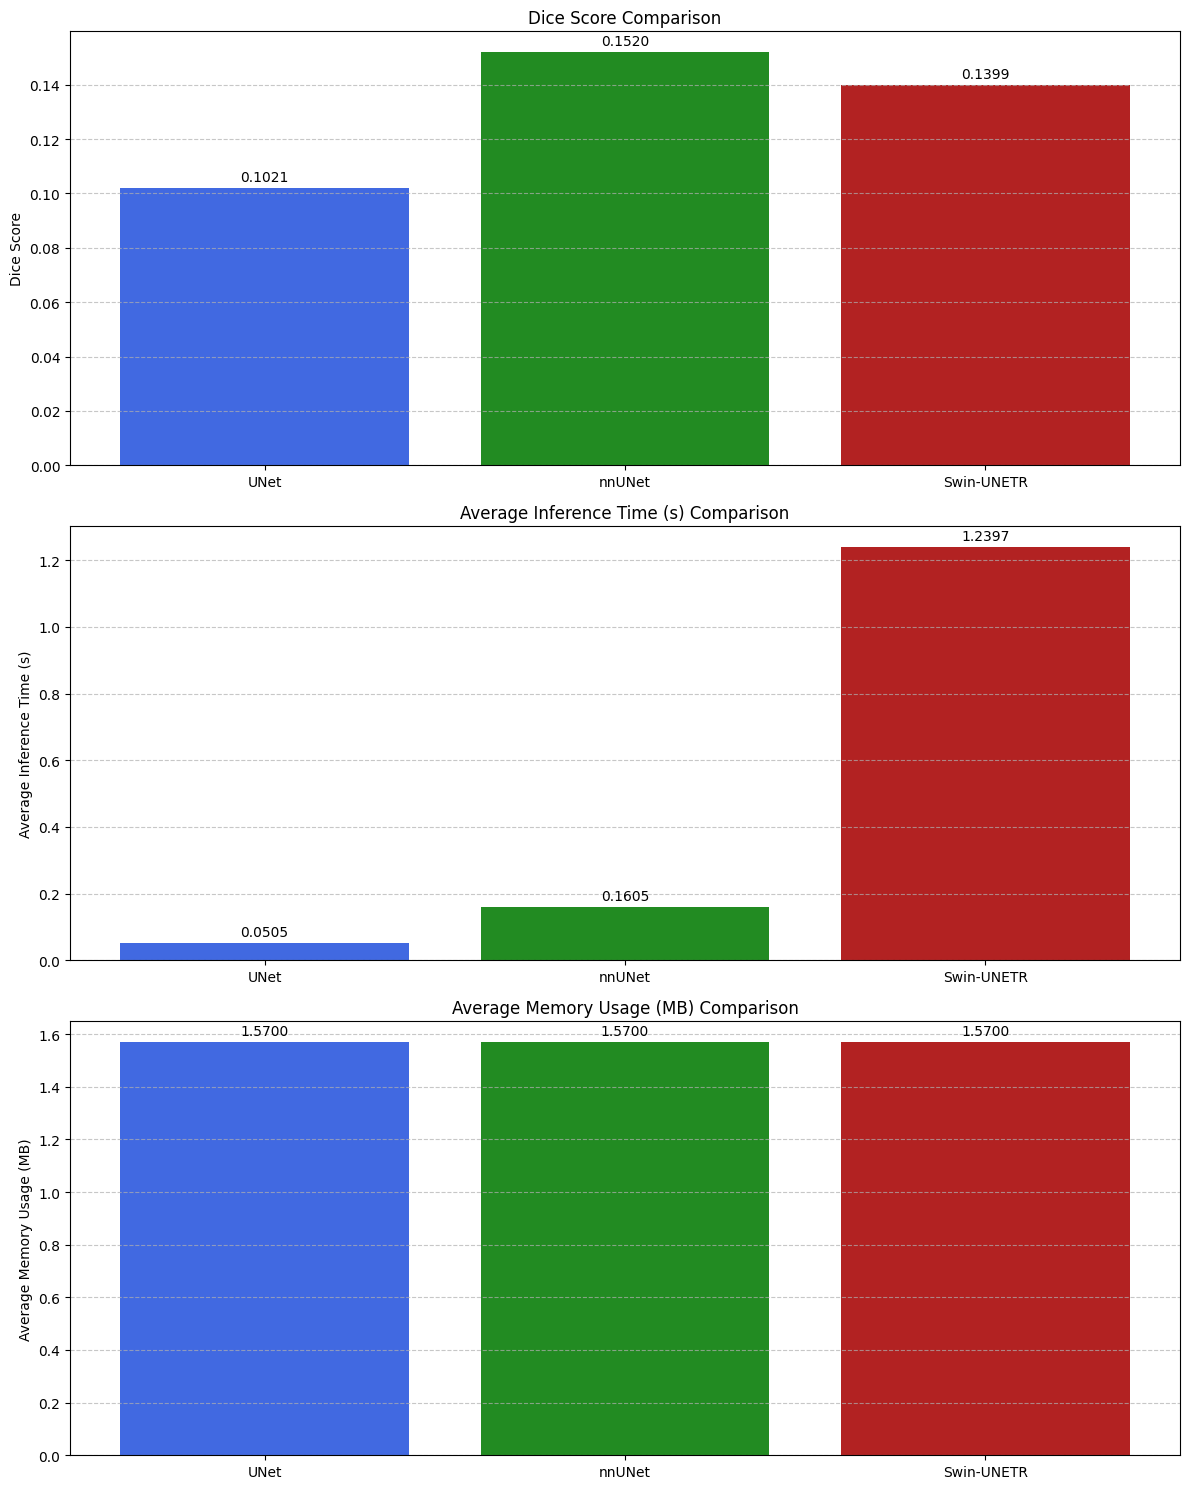

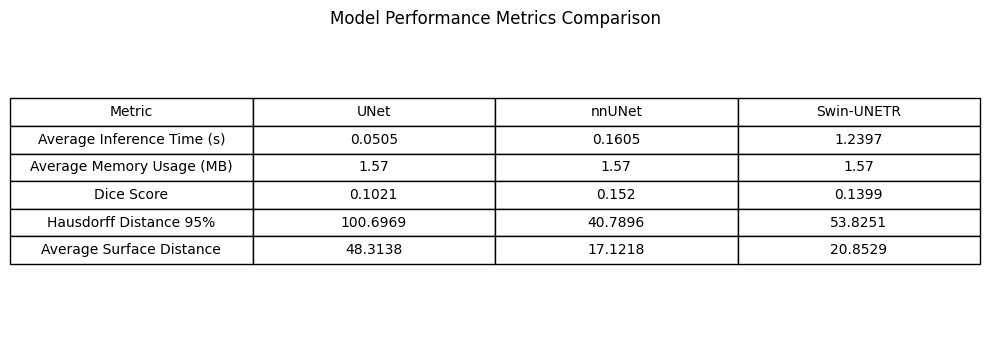

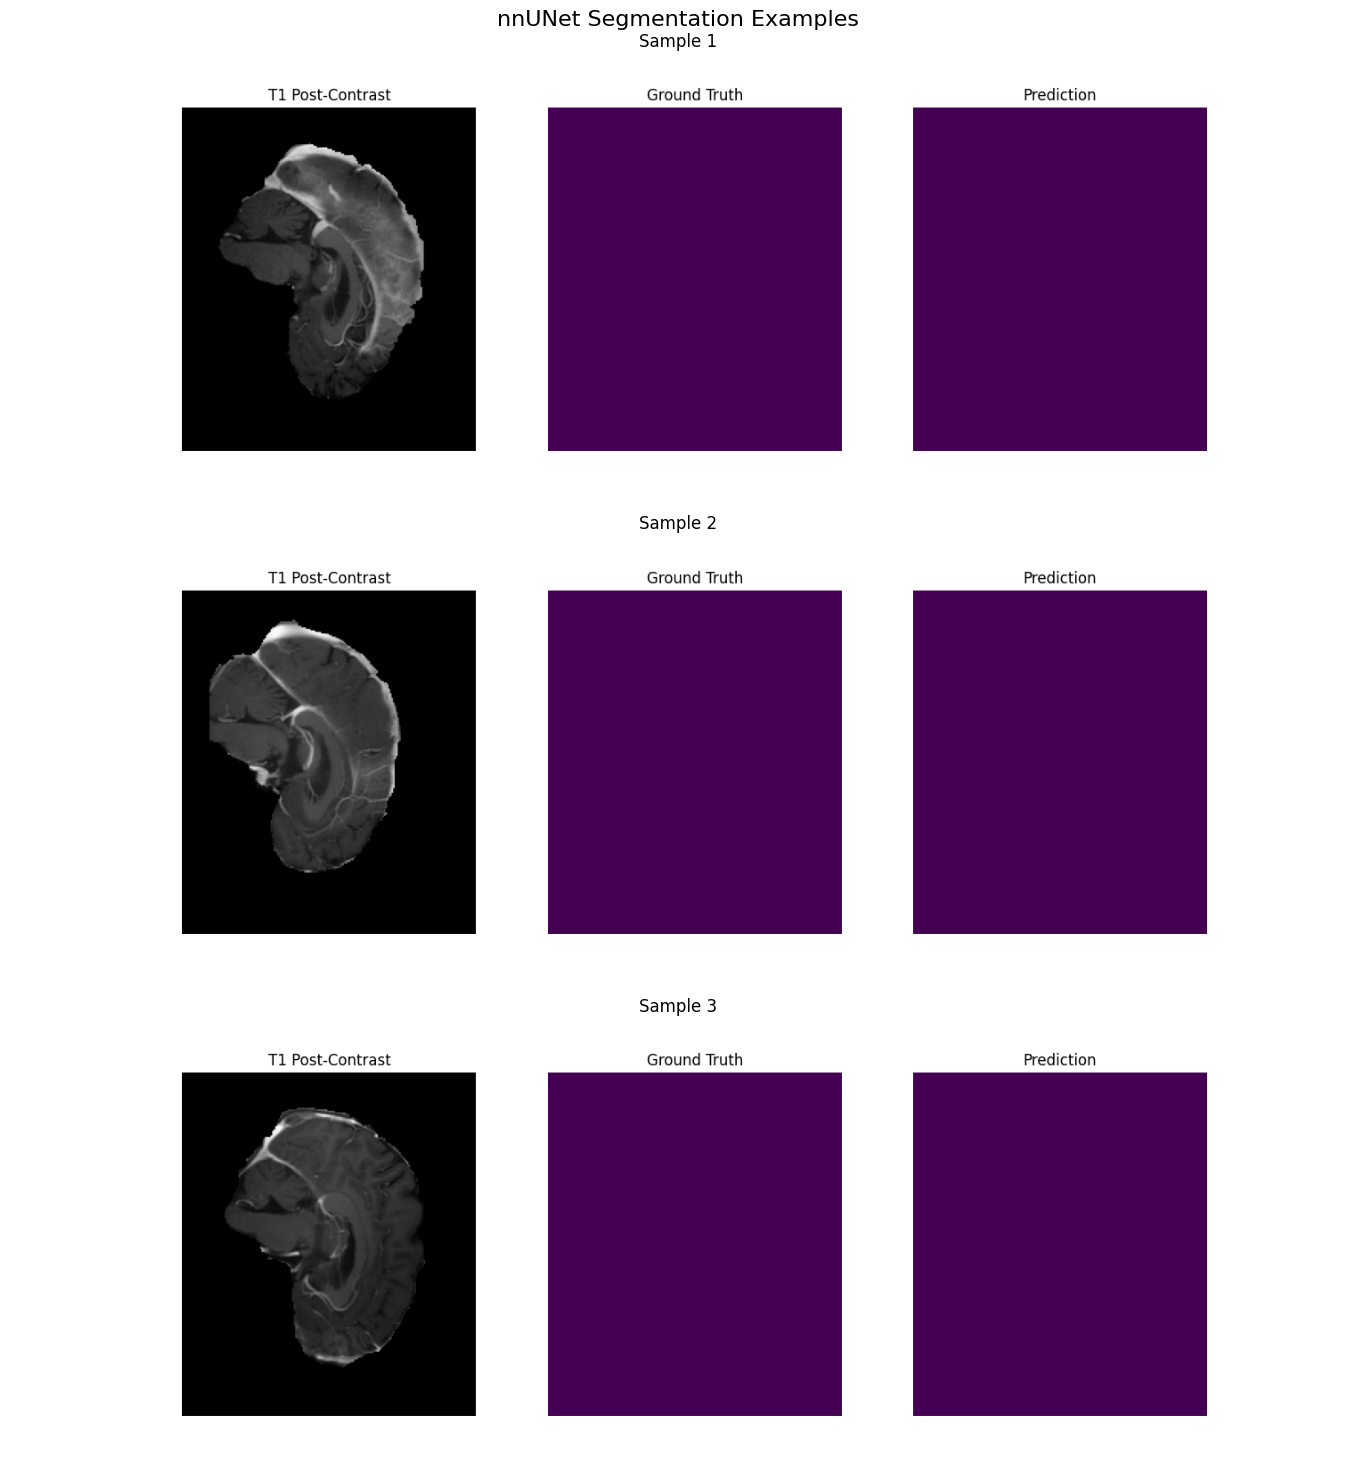

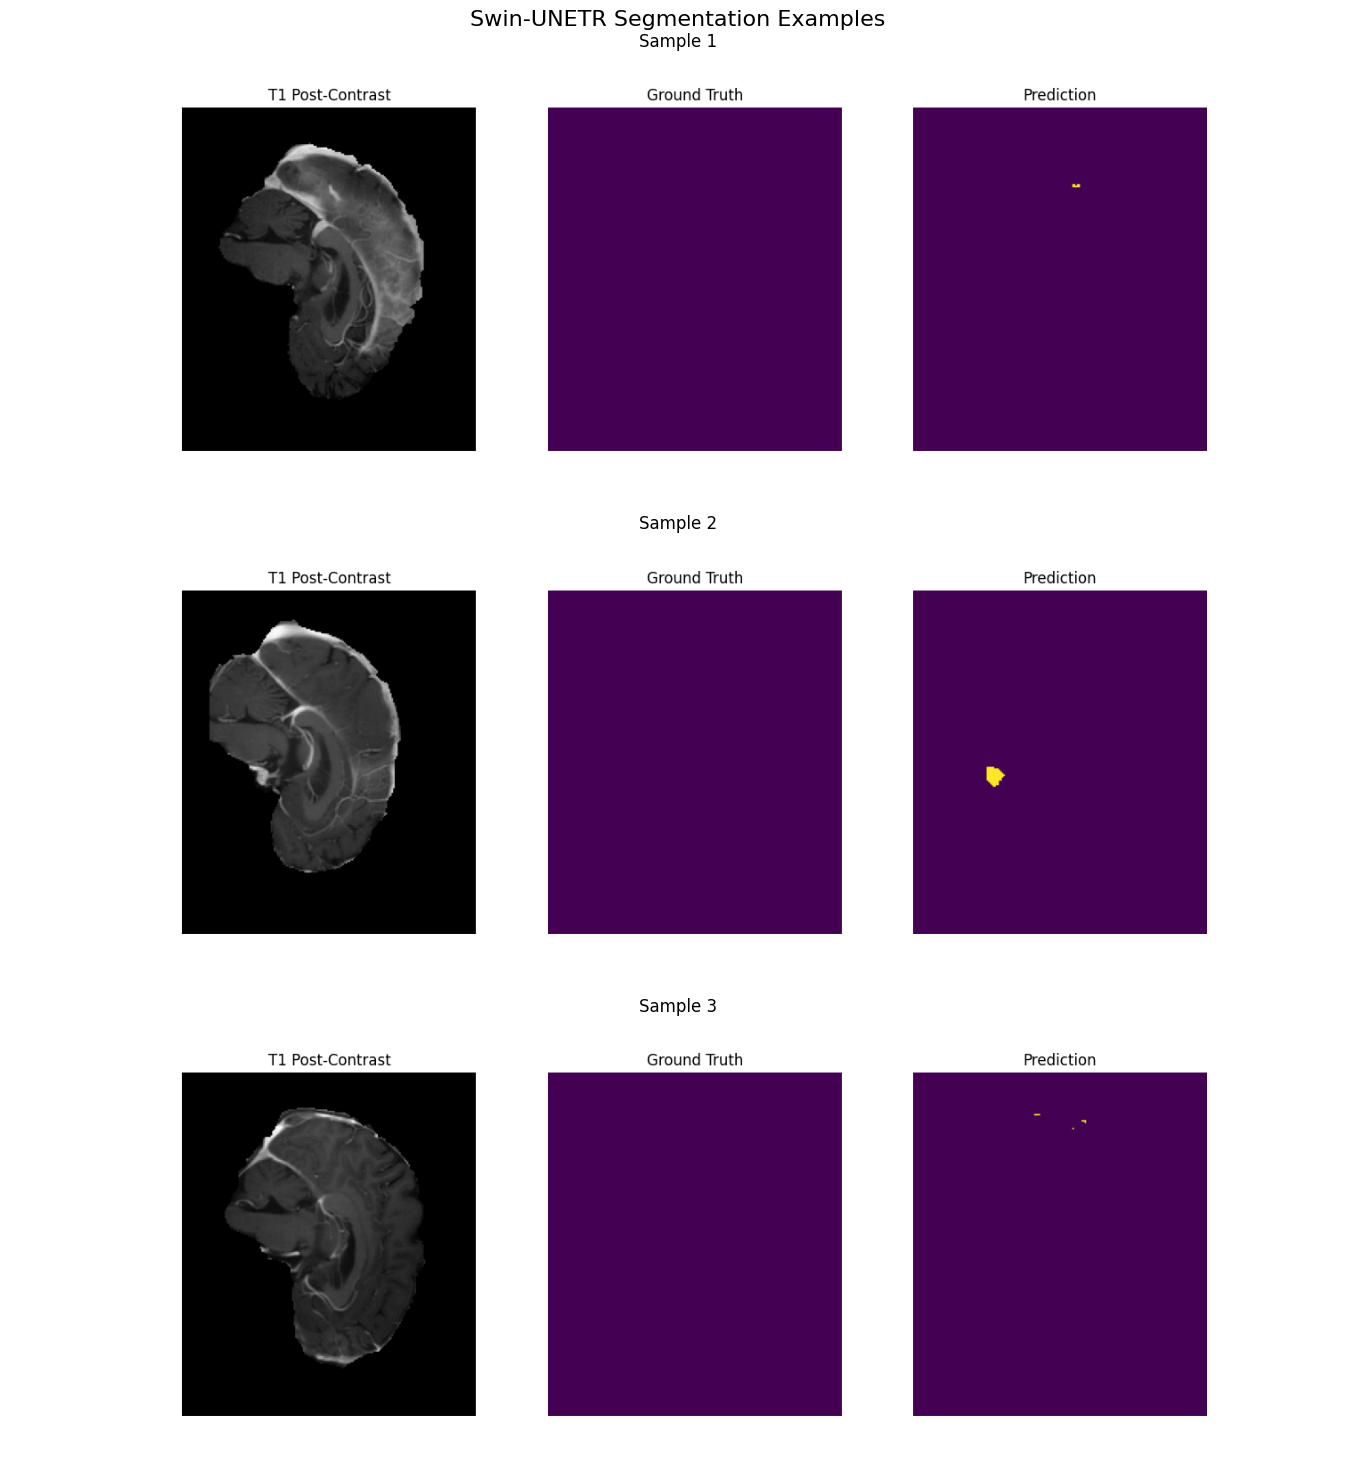

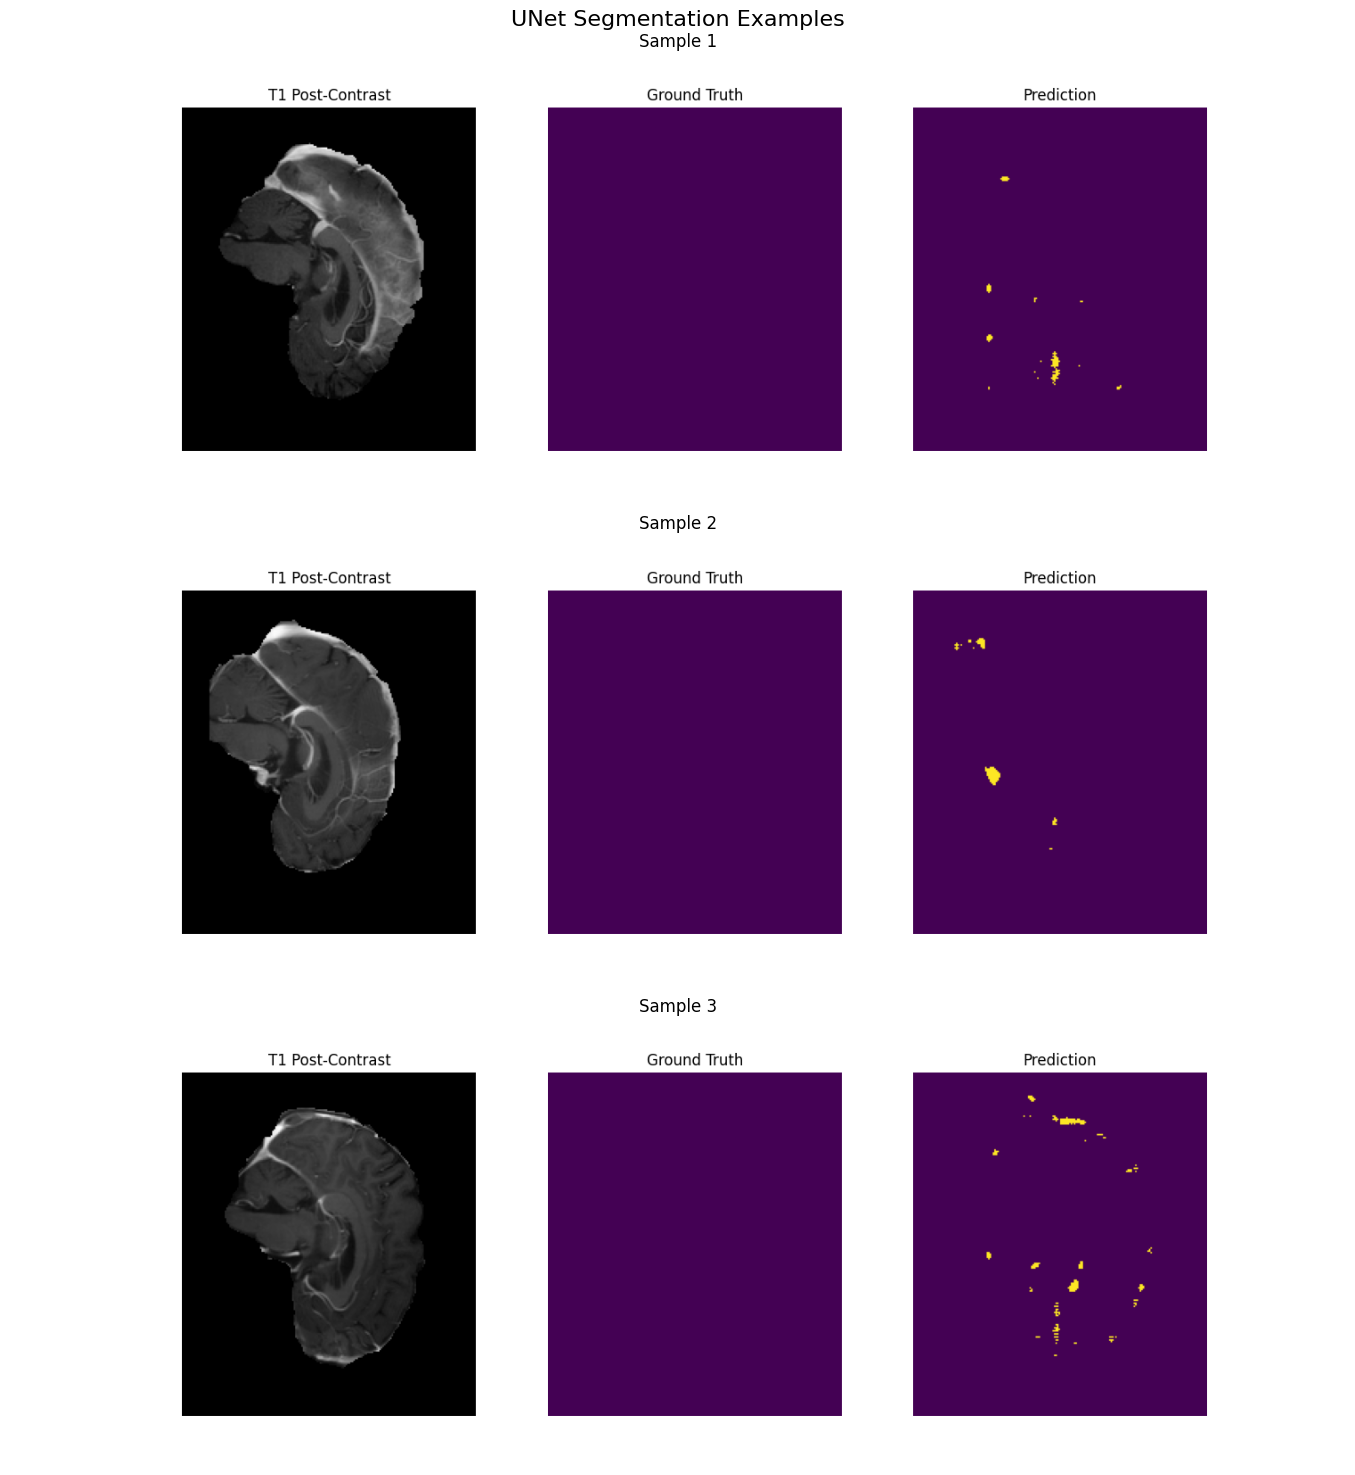

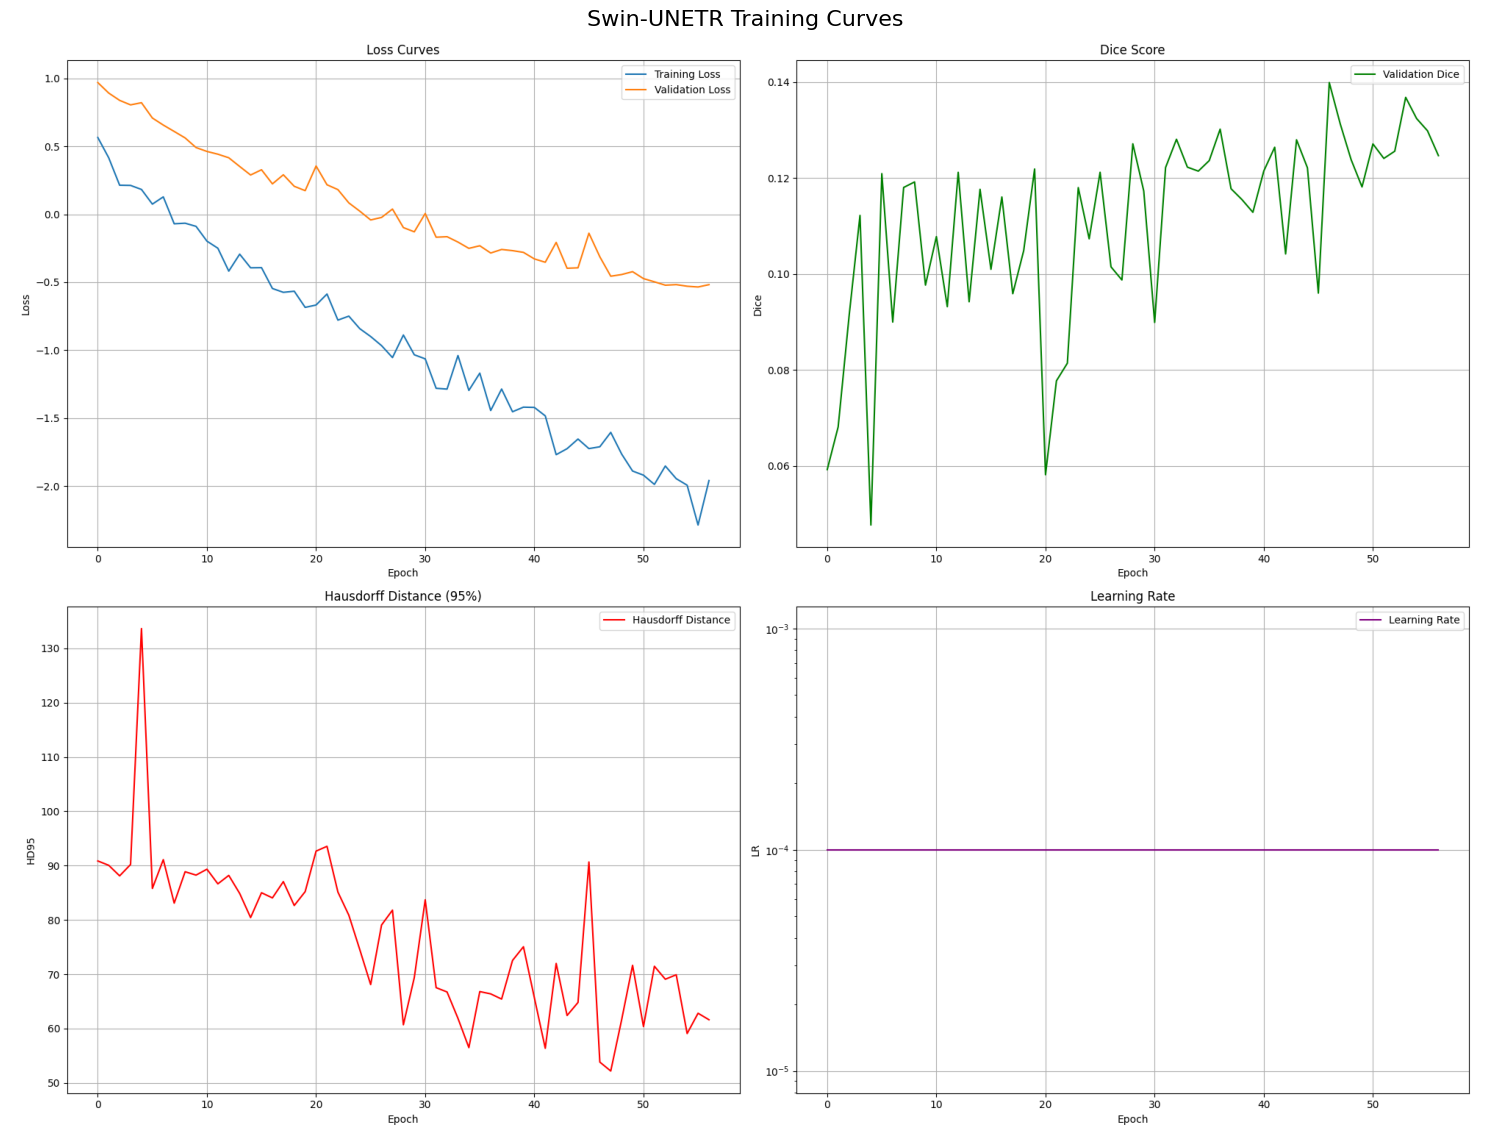

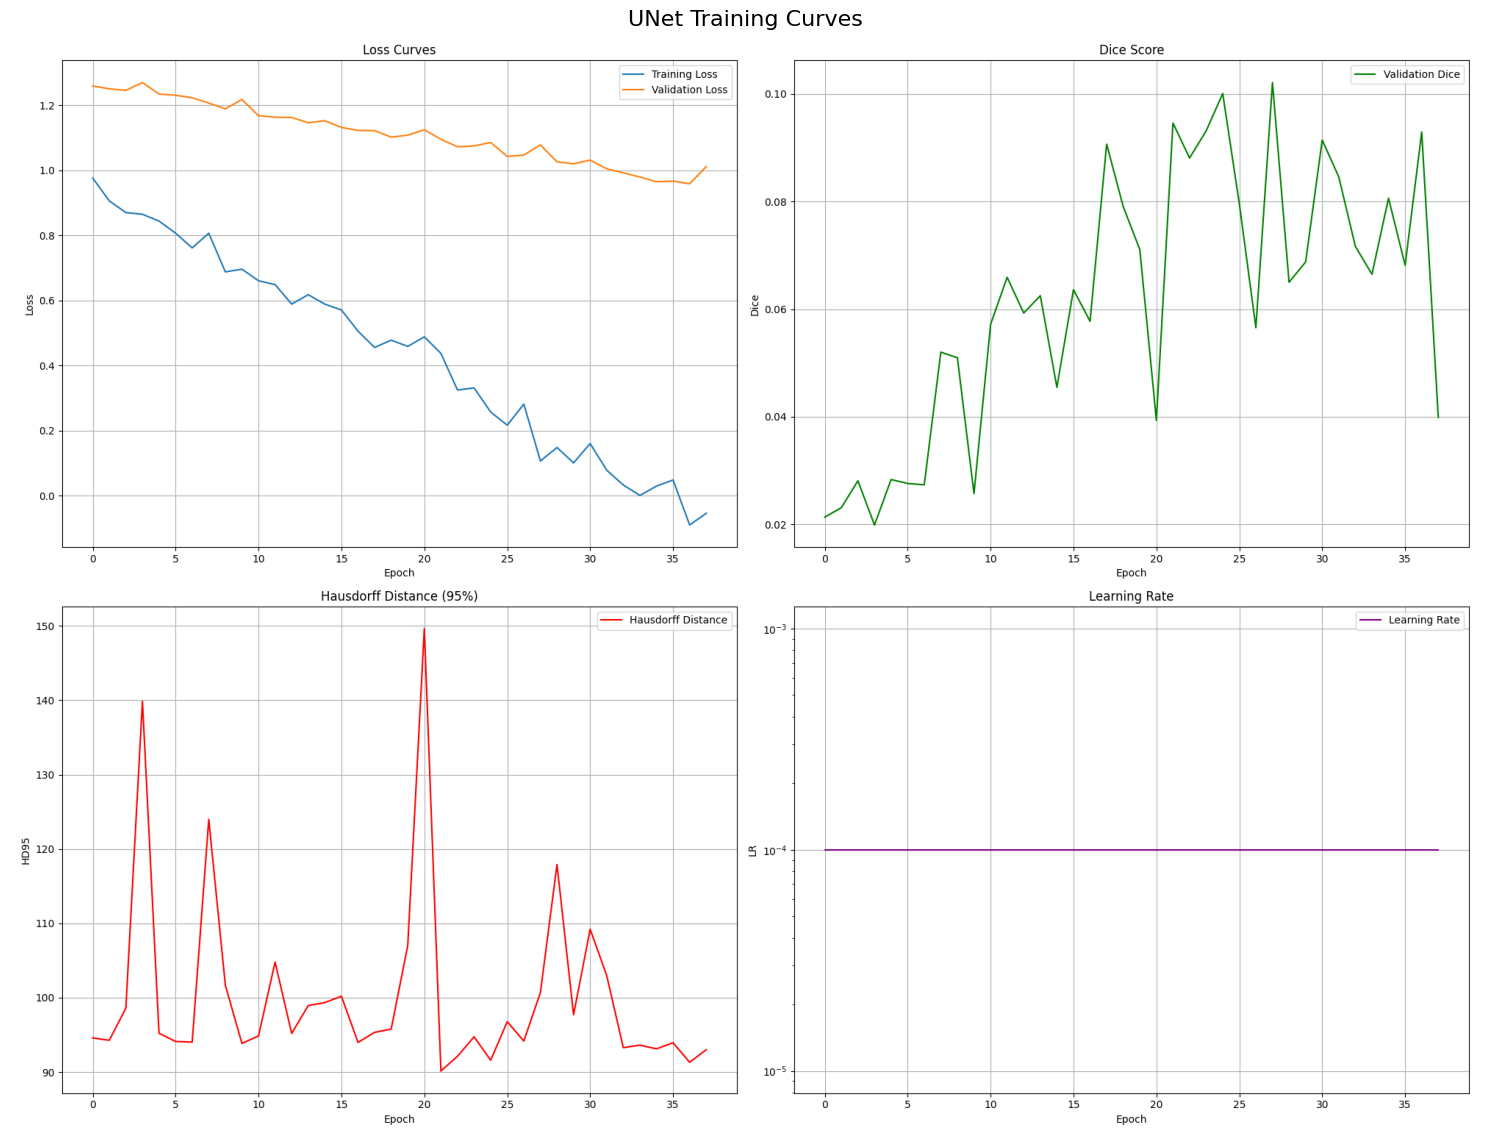

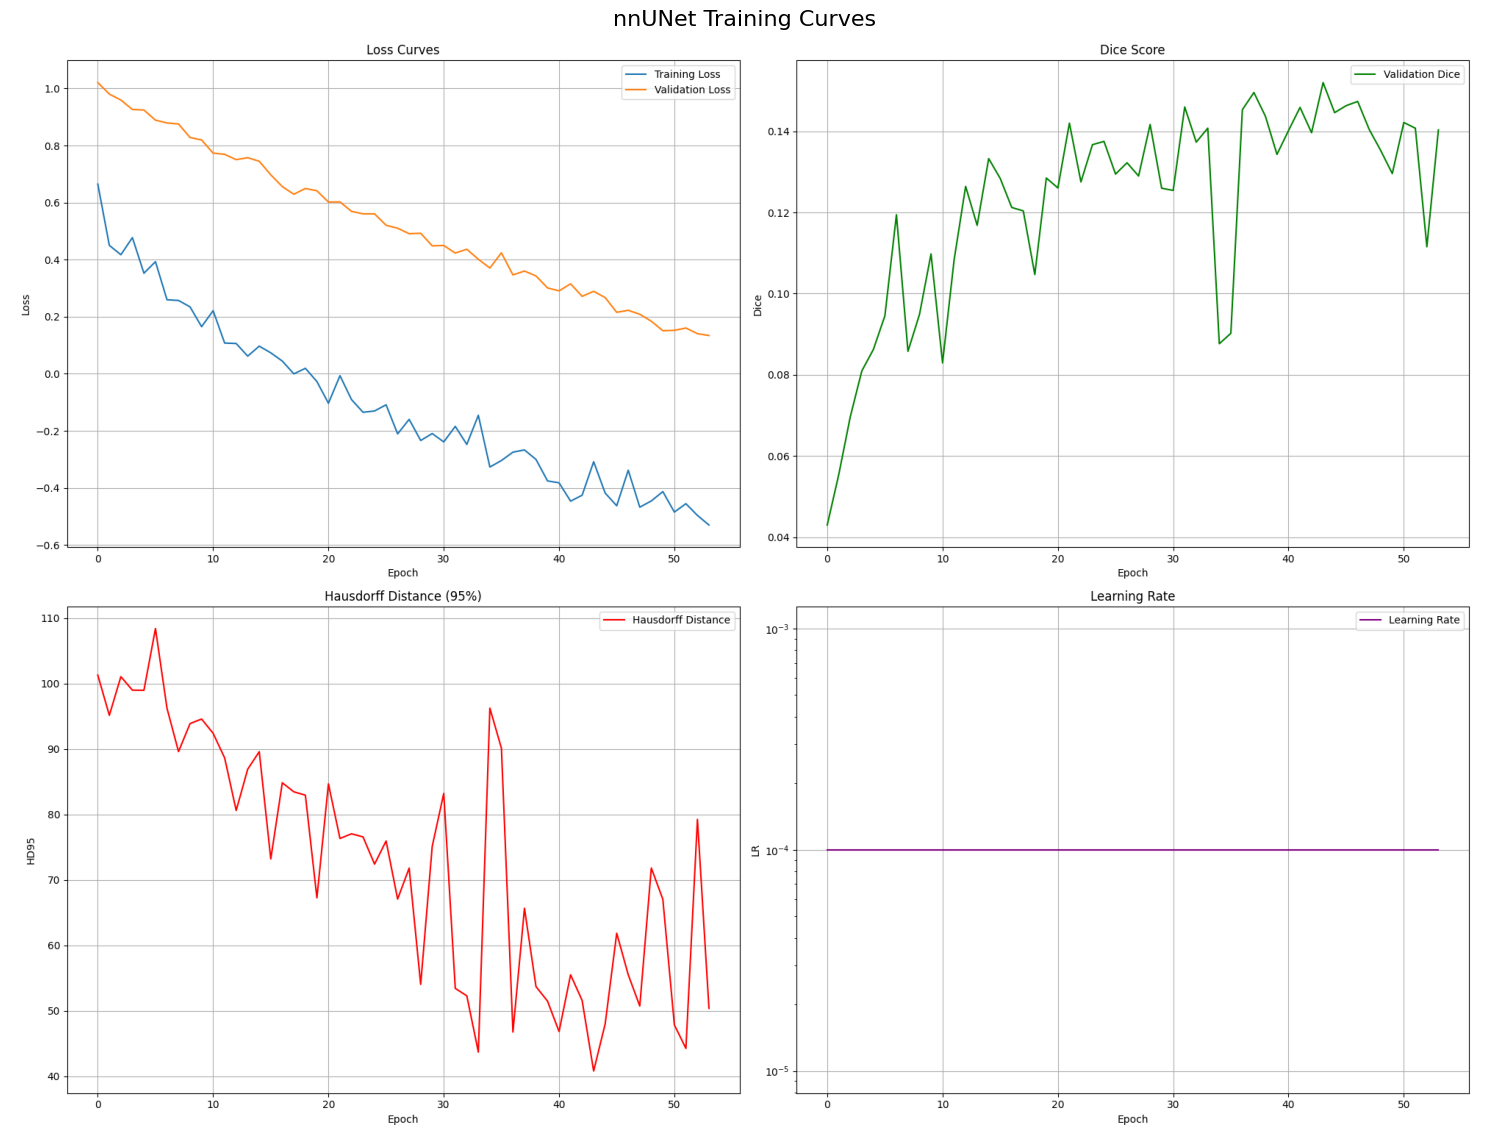

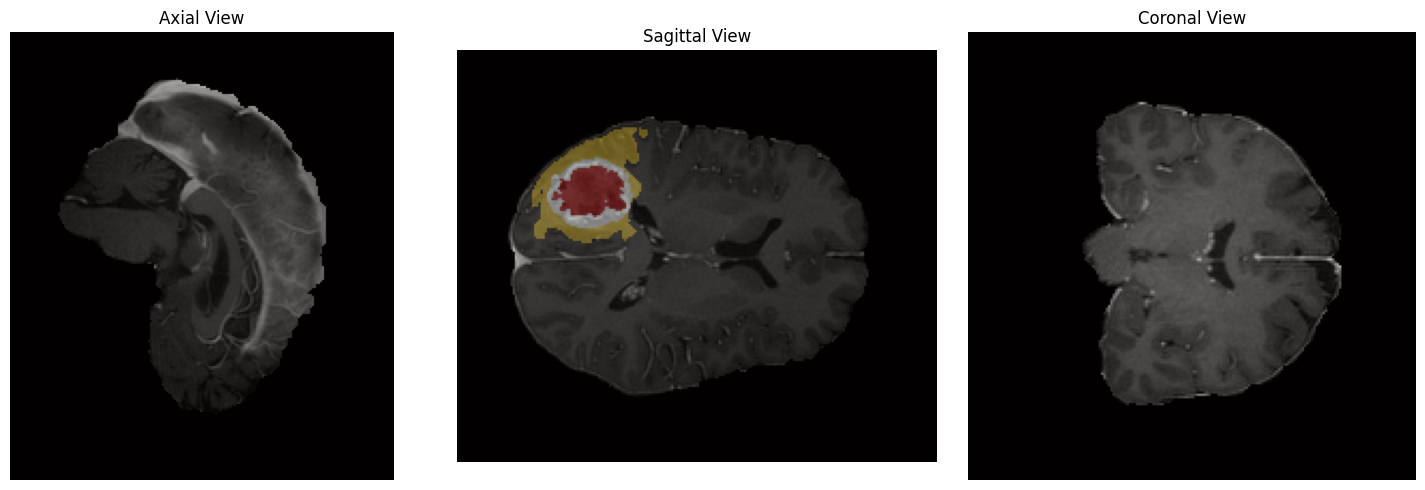

In [ ]:
def visualize_all_results():
    """
    Display and analyze all visualization results after model training
    """
    # Create output directory for combined visualizations
    os.makedirs("combined_visualizations", exist_ok=True)

    # 1. Display model performance metrics
    model_metrics = {}

    # Load all result CSVs
    result_files = glob.glob("*_results.csv")

    for file in result_files:
        model_name = file.split("_results.csv")[0]
        try:
            df = pd.read_csv(file)
            # Convert to dictionary
            metrics = {row[0]: row[1] for _, row in df.iterrows()}
            model_metrics[model_name] = metrics
        except Exception as e:
            print(f"Could not load {file}: {e}")

    if model_metrics:
        # Plot comparison of key metrics
        metrics_to_plot = ["Dice Score", "Average Inference Time (s)", "Average Memory Usage (MB)"]

        fig, axs = plt.subplots(len(metrics_to_plot), 1, figsize=(12, 5*len(metrics_to_plot)))

        for i, metric in enumerate(metrics_to_plot):
            metric_values = []
            models = []

            for model, metrics in model_metrics.items():
                if metric in metrics:
                    models.append(model)
                    metric_values.append(metrics[metric])

            if metric_values:
                bars = axs[i].bar(models, metric_values, color=['royalblue', 'forestgreen', 'firebrick'])
                axs[i].set_title(f"{metric} Comparison")
                axs[i].set_ylabel(metric)
                axs[i].grid(axis='y', linestyle='--', alpha=0.7)

                # Add value labels
                for bar in bars:
                    height = bar.get_height()
                    axs[i].text(bar.get_x() + bar.get_width()/2., height + 0.01*max(metric_values),
                            f'{height:.4f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.savefig("combined_visualizations/metrics_comparison.png")
        plt.show()

        # Create a table of all metrics
        all_metrics = set()
        for metrics in model_metrics.values():
            all_metrics.update(metrics.keys())

        # Create table data
        table_data = []
        models = list(model_metrics.keys())

        for metric in all_metrics:
            row = [metric]
            for model in models:
                row.append(model_metrics[model].get(metric, "N/A"))
            table_data.append(row)

        fig, ax = plt.subplots(figsize=(10, len(all_metrics)*0.5 + 1))
        ax.axis('off')

        table = ax.table(
            cellText=table_data,
            colLabels=["Metric"] + models,
            loc='center',
            cellLoc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)

        plt.title("Model Performance Metrics Comparison")
        plt.tight_layout()
        plt.savefig("combined_visualizations/metrics_table.png")
        plt.show()

    # 2. Display sample segmentations
    visualization_files = glob.glob("visualizations/*.png")

    # Group by model
    model_visualizations = {}
    for file in visualization_files:
        filename = os.path.basename(file)
        model_name = filename.split("_sample_")[0]

        if model_name not in model_visualizations:
            model_visualizations[model_name] = []

        model_visualizations[model_name].append(file)

    # Display a few samples for each model
    for model, files in model_visualizations.items():
        # Sort files to get consistent order
        files = sorted(files)
        # Display up to 3 samples per model
        num_samples = min(3, len(files))

        plt.figure(figsize=(15, 5*num_samples))
        plt.suptitle(f"{model} Segmentation Examples", fontsize=16)

        for i in range(num_samples):
            img = plt.imread(files[i])
            plt.subplot(num_samples, 1, i+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Sample {i+1}")

        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.savefig(f"combined_visualizations/{model}_samples.png")
        plt.show()

    # 3. Display training curves
    training_curve_files = glob.glob("*_training_curves.png")

    for file in training_curve_files:
        model_name = file.split("_training_curves.png")[0]
        img = plt.imread(file)

        plt.figure(figsize=(15, 12))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{model_name} Training Curves", fontsize=16)
        plt.tight_layout()
        plt.show()

    # 4. Combined visualization with 3D volume rendering (if available)
    try:
        # Check if we have the first sample data
        check_data = first(val_loader)
        inputs, labels = check_data["image"], check_data["seg"]

        # Get first sample and move to CPU
        input_sample = inputs[0].cpu().numpy()
        label_sample = labels[0].cpu().numpy()

        # Create 3D visualization with orthogonal slices
        fig = plt.figure(figsize=(15, 5))

        # Show mid slices from each view
        H, W, D = input_sample.shape[1:]

        # Axial view (top down)
        ax1 = fig.add_subplot(131)
        ax1.imshow(input_sample[0, H//2, :, :], cmap='gray')
        ax1.imshow(label_sample[0, H//2, :, :], cmap='hot', alpha=0.3)
        ax1.set_title("Axial View")
        ax1.axis('off')

        # Sagittal view (side)
        ax2 = fig.add_subplot(132)
        ax2.imshow(input_sample[0, :, :, D//2], cmap='gray')
        ax2.imshow(label_sample[0, :, :, D//2], cmap='hot', alpha=0.3)
        ax2.set_title("Sagittal View")
        ax2.axis('off')

        # Coronal view (front)
        ax3 = fig.add_subplot(133)
        ax3.imshow(input_sample[0, :, W//2, :], cmap='gray')
        ax3.imshow(label_sample[0, :, W//2, :], cmap='hot', alpha=0.3)
        ax3.set_title("Coronal View")
        ax3.axis('off')

        plt.tight_layout()
        plt.savefig("combined_visualizations/3d_visualization.png")
        plt.show()
    except Exception as e:
        print(f"Could not create 3D visualization: {e}")

# Call the visualization function
print("Displaying visualizations...")
visualize_all_results()